#Test machine learning models Moentschele Project


## Import modules and create test data

In [2]:
#Import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from collections import Counter
from joblib import dump, load
from skimage import io
from time import sleep
from IPython.display import clear_output

In [3]:
# define data directory
DATADIR = "../data/"
ORIGINALS_DIR = DATADIR+"/Originals/"

# change: import labels
label_df = pd.read_csv(DATADIR+"labels_test_set.csv")

label_df = label_df.rename(columns={"Unnamed: 0": "img"})

# retain only labels / img with meaningful label
label_df = label_df[label_df["wind_force"] != "0"]

# array with img names of labeled img
labeled_img = label_df["img"].to_numpy()

# create numeric wind force variable
label_df["wind_force_num"] = np.where(label_df["wind_force"] == "n", 0,
                             np.where(label_df["wind_force"] == "w", 1,
                             np.where(label_df["wind_force"] == "m", 2,
                             np.where(label_df["wind_force"] == "s", 3, -1))))

In [4]:
# fun to crop img
def fn_crop_image(img_array, y_start, x_start):
    y_heigth = 60 #ursprünglich 80
    x_width = 110
    
    crop_image = img_array[y_start:y_start+y_heigth,x_start:x_start+x_width] # set RGB to 0 to only analyze red chanel
    return crop_image

# Define wind force class names
wind_force_class_names = ["No wind","Weak wind force","Middle wind force","Strong wind force"] #label_df enthält effektiv nur 4 Kategorien, prüfen! (Problem bei Plot Predictions)

In [6]:
# Create Test-Data
test_data = []
def create_test_data():
    for img in labeled_img:
        path = os.path.join(ORIGINALS_DIR, img)
        img_array = cv2.imread(os.path.join(path))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
        new_array = fn_crop_image(img_array, 233, 560)
        wind_label = label_df.loc[label_df["img"] == img, "wind_force_num"] # get label to coresponding img
        wind_label = np.ndarray.item(wind_label.to_numpy()) # convert to single scalar integer
        test_data.append([new_array, wind_label])
    
create_test_data()

images = []
labels = []

for feature, label in test_data:
    images.append(feature)
    labels.append(label)

# mutate to np.array
np_images = np.array(images).reshape(-1, np.array(images).shape[1], np.array(images).shape[2], np.array(images).shape[3])
np_labels = np.array(labels)

#Check counts of labels
Counter(np_labels)

Counter({0: 6, 1: 26, 2: 11})

In [7]:
#Convert image shape
label_amount = np_labels.size

print(f"np_images shape: {np_images.shape}")
np_images_red = np_images[:,:,:,0] #reduce to red channel
print(f"np_images_red shape: {np_images_red.shape}")

np_images_red_flatten = np_images_red[:label_amount,:].reshape(label_amount,-1)
print(f"np_images_red_flatten shape: {np_images_red_flatten.shape}")

#1) Split into train and test set:
x_test = np_images_red_flatten
y_test = np_labels

print(f"np_labels shape: {np_labels.shape}")

np_images shape: (43, 60, 110, 3)
np_images_red shape: (43, 60, 110)
np_images_red_flatten shape: (43, 6600)
np_labels shape: (43,)


## Test the models

###Logistic Regression

In [9]:
#Load exported models:
#clf_filename = "model_clf_log_reg_noHarm_100.joblib"
#clf_filename = "model_clf_log_reg_noHarm_200.joblib"
#clf_filename = "model_clf_log_reg_noHarm_300.joblib"
#clf_filename = "model_clf_log_reg_noHarm_1000.joblib"
#clf_filename = "model_clf_log_reg_noHarm_2500.joblib"

#clf_filename = "model_clf_log_reg_harm_100.joblib"
clf_filename = "model_clf_log_reg_harm_200.joblib"

clf = load(DATADIR+clf_filename)



/Users/Christine/Documents/CAS_Moentschele_SourceCode/moentschele_project/.venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
# Create masks for wrong and right predictions and safe corresponding images names to np array
y_test_pred = clf.predict(x_test)

mask_wrong_pred = y_test_pred != y_test
mask_right_pred = y_test_pred == y_test

wrong_image_names = labeled_img[mask_wrong_pred]
right_image_names = labeled_img[mask_right_pred]

print(f"Wrong images: {wrong_image_names.size}, Right labels: {right_image_names.size}, Score: {clf.score(x_test,y_test)}")

Wrong images: 15, Right labels: 28, Score: 0.6511627906976745


In [11]:
#Get indices of wrong predictions to numpy array
idxs_wrong = np.flatnonzero(mask_wrong_pred)
idxs_right = np.flatnonzero(mask_right_pred)

#### Show images with results

Image: D20221006_124557_3444.jpg, Index: 0


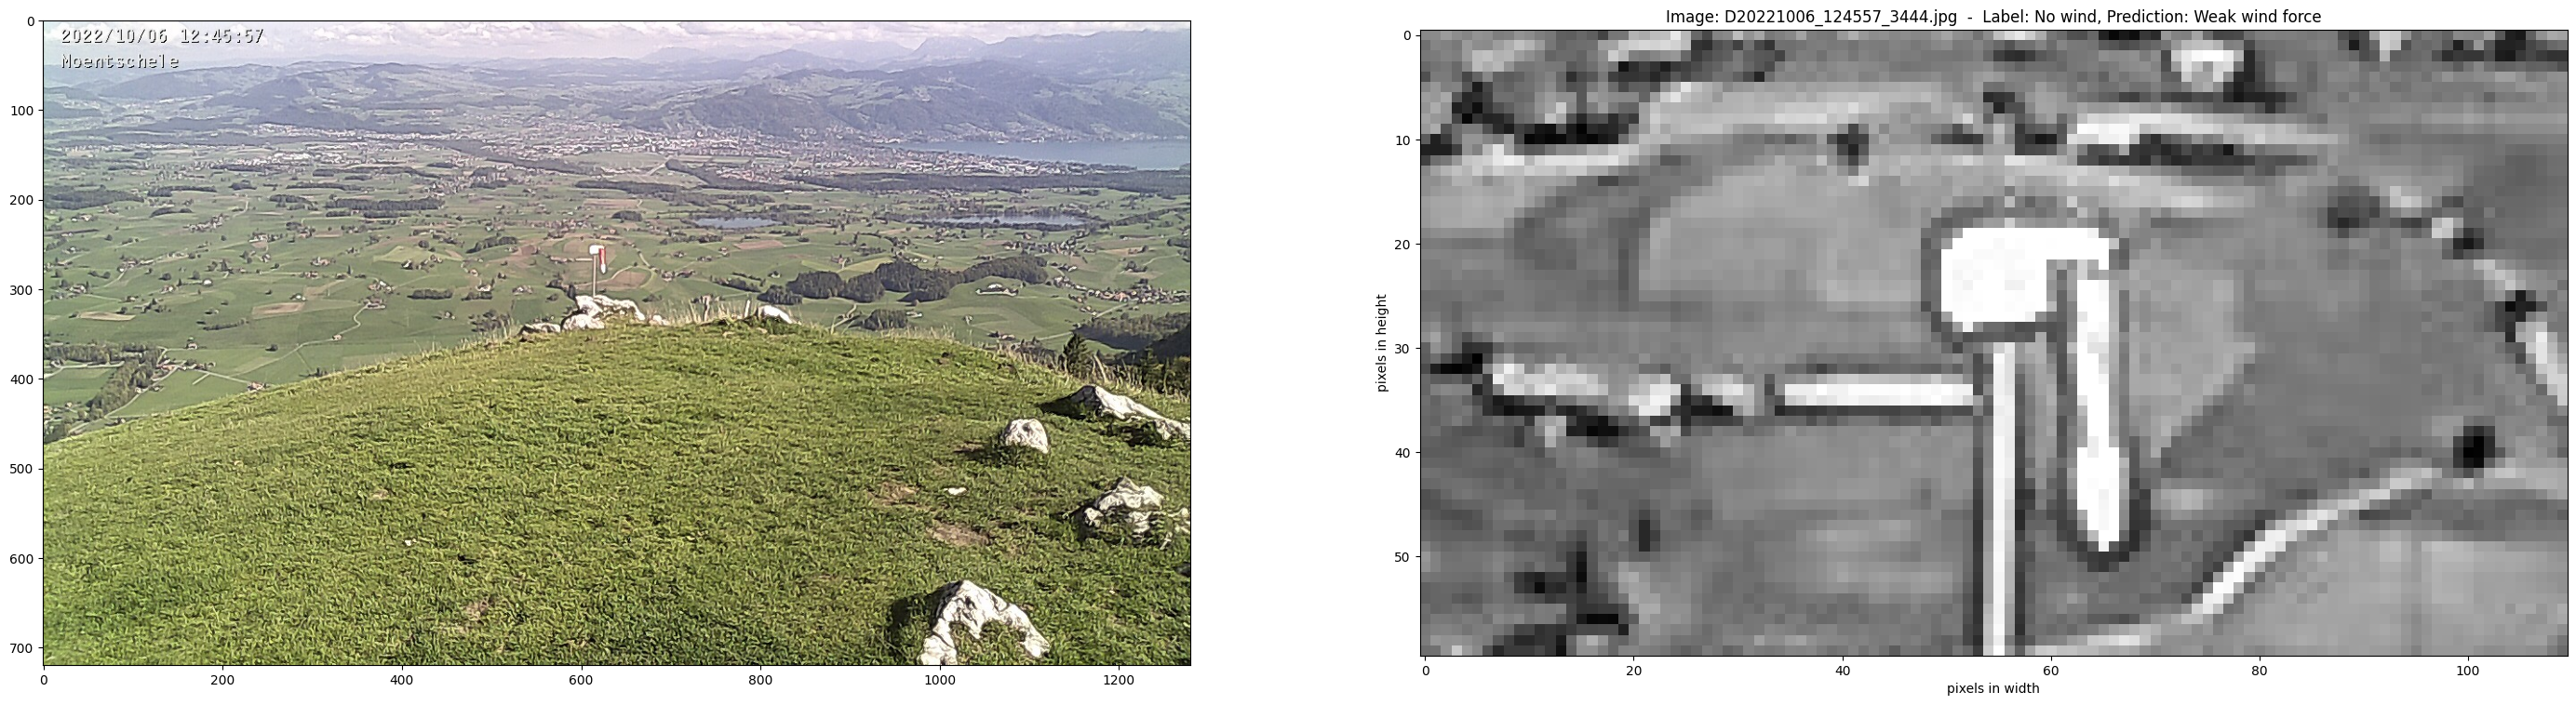

In [15]:
#Show images with right or wrong predictions
show_right = False
sleep_seconds = 1

if show_right:
  idxs = idxs_right
else:
  idxs = idxs_wrong

for idx in idxs:
  if y_test_pred[idx] != 99: #use to filter to predicted wind force
    image_name = labeled_img[idx]
    fig = plt.figure(1,figsize= (35,15))
    chart0 = fig.add_subplot(121)
    chart1 = fig.add_subplot(122)
    img_array = cv2.imread(os.path.join(ORIGINALS_DIR+image_name))
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
    new_array = fn_crop_image(img_array,233,560)
    new_array = new_array[:,:,0]
    print(f"Image: {image_name}, Index: {idx}")
    plt.title('Image: ' + image_name + '  -  Label: ' + wind_force_class_names[y_test[idx]] + ', Prediction: ' + wind_force_class_names[y_test_pred[idx]])
    plt.xlabel('pixels in width')
    plt.ylabel('pixels in height')
    chart0.imshow(img_array)
    chart1.imshow(new_array, cmap = 'gray')
    plt.show()
    sleep(sleep_seconds)
    answer = input("hit enter to continue or type exit..")
    if answer == "exit":
      break
    clear_output()

### Linear Regression

In [17]:
reg_filename = "model_lin_reg_harm.joblib"
#reg_filename = "model_lin_reg_noHarm.joblib"
reg = load(DATADIR+reg_filename)

/Users/Christine/Documents/CAS_Moentschele_SourceCode/moentschele_project/.venv/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [18]:
y_test_pred = reg.predict(x_test)

In [20]:
# Create masks for wrong and right predictions and safe corresponding images names to np array
mask_wrong_pred = np.rint(y_test_pred) != y_test #np.rint() --> round to nearest integer
mask_right_pred = np.rint(y_test_pred) == y_test

wrong_image_names = labeled_img[mask_wrong_pred]
right_image_names = labeled_img[mask_right_pred]

print(f"Wrong images: {wrong_image_names.size}, Right labels: {right_image_names.size}, Score: {reg.score(x_test,y_test)}")

Wrong images: 29, Right labels: 14, Score: -1.4603855779343444
